In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split

In [2]:
col_names = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
df_news = pd.read_csv('/Users/ryomisawa/Downloads/NewsAggregatorDataset/newsCorpora.csv', sep = '\t', names=col_names)

df_news = df_news[(df_news['PUBLISHER'] == 'Reuters') | (df_news['PUBLISHER'] ==  'Huffington Post')|(df_news['PUBLISHER'] == 'Businessweek') | (df_news['PUBLISHER'] == 'Contactmusic.com') |(df_news['PUBLISHER'] == 'Daily Mail')].sample(frac=1, random_state=0).reset_index()

In [3]:
df_train, df_valid = train_test_split(df_news, test_size=0.2)
df_valid, df_test = train_test_split(df_valid, test_size=0.5)
df_train.loc[:, ['TITLE','CATEGORY']].to_csv('/Users/ryomisawa/Library/Mobile Documents/com~apple~CloudDocs/nlp_tutorial/train.txt')
df_valid.loc[:, ['TITLE','CATEGORY']].to_csv('/Users/ryomisawa/Library/Mobile Documents/com~apple~CloudDocs/nlp_tutorial/valid.txt')
df_test.loc[:, ['TITLE','CATEGORY']].to_csv('/Users/ryomisawa/Library/Mobile Documents/com~apple~CloudDocs/nlp_tutorial/test.txt')
print(df_train['TITLE'].value_counts().sum())
print(df_valid['TITLE'].value_counts().sum())
print(df_test['TITLE'].value_counts().sum())

10672
1334
1334


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vec= CountVectorizer()
train = vec.fit_transform(df_train['TITLE'])
valid = vec.transform(df_valid['TITLE'])
test = vec.transform(df_test['TITLE'])
np.savetxt('/Users/ryomisawa/nlp_tutorial/train_feature.txt', train.toarray(), fmt='%d')
np.savetxt('/Users/ryomisawa/nlp_tutorial/valid_feature.txt', valid.toarray(), fmt='%d')
np.savetxt('/Users/ryomisawa/nlp_tutorial/test_feature.txt', test.toarray(), fmt='%d')

In [6]:
from sklearn.linear_model import LogisticRegression
x = train
y = df_train['CATEGORY']
model = LogisticRegression()
model.fit(x, y)

LogisticRegression()

In [7]:
def pred(x):
    return model.predict(x)

In [8]:
print(pred(train))
print(pred(test))

['b' 'e' 'b' ... 'e' 'm' 'b']
['b' 't' 'e' ... 'b' 'b' 'e']


In [9]:
print(model.score(train, df_train['CATEGORY']))
print(model.score(test, df_test['CATEGORY']))

0.9963455772113943
0.9010494752623688


In [10]:
df_valid['CATEGORY'].values

array(['b', 'e', 'b', ..., 'e', 'e', 'b'], dtype=object)

In [11]:
from sklearn.metrics import confusion_matrix

a = confusion_matrix(df_train['CATEGORY'], pred(train), labels= ['b','e','m','t'])
b = confusion_matrix(df_test['CATEGORY'], pred(test), labels=['b','e','m','t'])
print(a)
print(b)

[[4476    2    0    5]
 [   7 4248    0    2]
 [   4    2  720    0]
 [  15    2    0 1189]]
[[533  18   3  17]
 [ 10 501   1   2]
 [  6  18  61   3]
 [ 29  22   3 107]]


In [12]:
b.sum()

1334

In [13]:
category = ['b','e','m','t']
micro_average = {}
macro_average = {}
for i in range(4):
    pre = b[i, i]/b[:, i].sum()
    recall = b[i, i]/b[i, :].sum()
    f1 = 2 * (pre * recall) / (pre + recall)
    macro_average[category[i]] = (pre + recall + f1)/3 
print(macro_average)

microaverage = (b[0, 0] + b[1, 1] + b[2, 2] + b[3, 3])/ b.sum()
print(microaverage)

{'b': 0.9277862295653966, 'e': 0.9349272816348662, 'm': 0.7907639745875041, 't': 0.7439948907052565}
0.9010494752623688


In [14]:
bigger = sorted(model.coef_.sum(axis=0), reverse=True)[0:10]
smaller = sorted(model.coef_.sum(axis=0))[0:10]
print(bigger)
print(smaller)

[4.829470157119431e-15, 4.6629367034256575e-15, 4.385380947269368e-15, 4.3021142204224816e-15, 3.774758283725532e-15, 3.552713678800501e-15, 3.497202527569243e-15, 3.3306690738754696e-15, 3.3306690738754696e-15, 3.219646771412954e-15]
[-7.549516567451064e-15, -4.9404924595819466e-15, -4.579669976578771e-15, -4.551914400963142e-15, -4.440892098500626e-15, -4.052314039881821e-15, -3.774758283725532e-15, -3.6637359812630166e-15, -3.6637359812630166e-15, -3.552713678800501e-15]


In [15]:
c = np.logspace(-3, 2, num=6)
train_score = []
valid_score = []
test_score = []
for i in c:
    model = LogisticRegression(C=i)
    model.fit(x, y)
    train_score.append(model.score(train, df_train['CATEGORY']))
    valid_score.append(model.score(valid, df_valid['CATEGORY']))
    test_score.append(model.score(test, df_test['CATEGORY']))
print(train_score)

[0.7285419790104948, 0.7874812593703149, 0.9270052473763118, 0.9963455772113943, 0.9993440779610195, 0.9993440779610195]


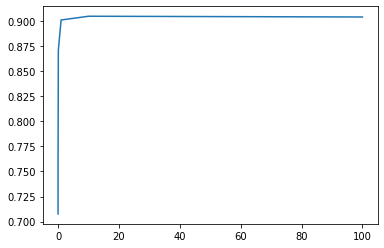

In [16]:
import matplotlib.pyplot as plt
x = c
y = test_score
plt.plot(x, y)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

param_grid_1 = {'C':np.logspace(-2, 2, num=5)}
param_grid_2 = {'C':np.logspace(-2, 2, num=5),'gamma':np.logspace(-2, 2, num=5)}
param_grid_3 = {'criterion':['gini', 'entropy'],
                'splitter':['best', 'random'],
                'max_depth':[i for i in range(1, 11)]}
param_grid_4 = {'n_neighbors':[i for i in range(1, 11)],
                'weights':['uniform', 'distance'],
                'p':[1, 2]}


gs_1 = GridSearchCV(estimator=LogisticRegression(),
                    param_grid=param_grid_1,
                    cv=5)
gs_2 = GridSearchCV(estimator=SVC(),
                    param_grid=param_grid_2,
                    cv=5)
gs_3 = GridSearchCV(estimator=DecisionTreeClassifier(),
                    param_grid=param_grid_3,
                    cv=5)
gs_4 = GridSearchCV(estimator=KNeighborsClassifier(),
                    param_grid=param_grid_4,
                    cv=5)

gs_1.fit(train, df_train['CATEGORY'])
gs_2.fit(train, df_train['CATEGORY'])
gs_3.fit(train, df_train['CATEGORY'])
gs_4.fit(train, df_train['CATEGORY'])

valid_score = {'LogisticRegression':gs_1.score(valid, df_valid['CATEGORY']), 'SVC':gs_2.score(valid, df_valid['CATEGORY']), 'DecisionTreeClassifier':gs_3.score(valid, df_valid['CATEGORY']), 'KNeighborsClassifier':gs_4.score(valid, df_valid['CATEGORY'])}         

In [21]:
max(valid_score, key=valid_score.get)
valid_score

{'LogisticRegression': 0.9115442278860569,
 'SVC': 0.9145427286356822,
 'DecisionTreeClassifier': 0.568215892053973,
 'KNeighborsClassifier': 0.704647676161919}

In [20]:
print(gs_2.best_score_)
print(gs_2.best_params_)
print(gs_2.score(test, df_test['CATEGORY']))

0.9049846688717738
{'C': 100.0, 'gamma': 0.01}
0.9055472263868066
